<a href="https://colab.research.google.com/github/Patric-Ramz/Patric-Ramz/blob/main/Cape_town_fire_data_analysis/capetownfire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Heading

In [ ]:
install.packages(c("broom", "geojsonio", "here", "lubridate", "tidyverse", "shiny", "httr"))

In [ ]:
library(broom)
library(here)
library(lubridate)
library(tidyverse)
library(shiny)
library(googledrive)
library(httr)
drive_auth()

file1 <- "data.csv"
file2 <- "CapeTownMap.geojson"
file3 <- "lookup.csv"

In [ ]:
q1 <- read_csv("data.csv")

q2 <- q1 %>%
  pivot_longer(4:ncol(q1), names_to = "Sub Category", values_to = "Count")

q3 <- q2 %>% filter(!is.na(Count))

q4 <- q3 %>%
  mutate(Category = str_extract(q3$`Sub Category`, "^[^-]+"))%>%
  mutate("Sub Category" = str_replace(q3$`Sub Category`, "^[^-]+-(.*)", "\\1")) %>%
  select( "Month", "Day", "Suburb", "Category", "Sub Category", "Count")

q5 <- q4 %>% group_by(`Sub Category`) %>% summarise(Count = sum(Count)) %>%
  filter(Count > 10) %>%
  semi_join(q4, ., by = "Sub Category")

In [13]:
q6 <- q5 %>% mutate(Year = 2018) %>%
  mutate(Date = make_date(Year, Month, Day)) %>%
  select("Date", "Suburb", "Category", "Sub Category", "Count") %>%
  mutate(Weekday = factor(wday(Date), levels = 1:7,
                          labels = c("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")))

Weekday_incidents <- q6 %>%
  filter(Weekday %in% c("Mon", "Tue", "Wed", "Thu", "Fri")) %>%
  summarize(total_instances = sum(Count))

Weekend_incidents <- q6 %>%
  filter(Weekday %in% c("Sun", "Sat")) %>%
  summarize(total_instances = sum(Count))

incidents <- function(x = Weekday_incidents,y = Weekend_incidents) {
  message(paste0("The number weekday incidents is ",
                 x, " and the number of weekend incidents is ", y))
}

incidents()

The number weekday incidents is 16192 and the number of weekend incidents is 7152



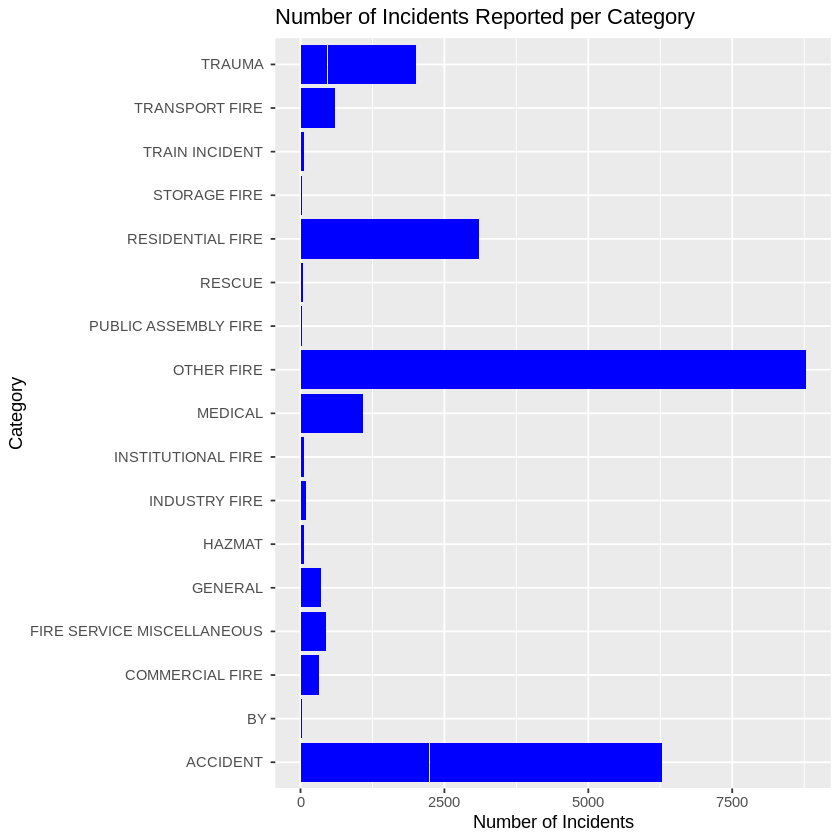

In [14]:
ggplot(q5, aes(x = Count, y = Category)) +
  geom_bar(stat = "identity", fill = "blue") +
  labs(title = "Number of Incidents Reported per Category",
       x = "Number of Incidents", y = "Category")

In [ ]:
ui <- fluidPage(

    # Application title
    titlePanel("Cape Town Fire Data"),

    # Sidebar with a slider input for number of categories

    sidebarLayout(
    sidebarPanel(
    sliderInput("num_categories", label = "Number of Categories", min = 1,
                max = 17, value = 4, step = 1)),

        # Show a plot of the generated distribution
        mainPanel(
           plotOutput("fire_plot")
        )
    )
)

# Define the server
server <- function(input, output) {
  output$fire_plot <- renderPlot({

    my_summary <- selected_categories <- q5 %>%
      group_by(Category) %>%
      summarize(Count = sum(Count)) %>%
      arrange(desc(Count))

    selected_categories <- head(my_summary$Category, input$num_categories)

    other_count <- q5 %>%
      filter(!Category %in% selected_categories) %>%
      summarise(Count = sum(Count)) %>%
      pull(Count)

    selected_data <- q5 %>%
      filter(Category %in% selected_categories)

    # Plot the data as a horizontal bar graph

    ggplot(selected_data, aes(x = Count, y = reorder(Category, -Count))) +
      geom_col(fill = "steelblue") +
      theme_minimal() +
      labs(title = "Number of Fires per Category",
           x = "Count",
           y = "Category")
  })
}

# Run the application
shinyApp(ui = ui, server = server)


Listening on http://127.0.0.1:3562



In [ ]:
# Run Shiny app on a specified port
port <- 8888
shiny_port <- as.character(port)

# Define URL to serveo endpoint
serveo_url <- paste0("http://", shiny_port, ".try.serveo.net")

# Start ngrok tunnel
response <- httr::POST("https://serveo.net:22",
                       body = list(port = shiny_port, host = "0.0.0.0"),
                       encode = "json")

# Extract serveo URL from response
serveo_url <- httr::content(response)$url
print(paste("http://127.0.0.1:3562", serveo_url))

`summarise()` has grouped output by 'Months'. You can override using the
`.groups` argument.


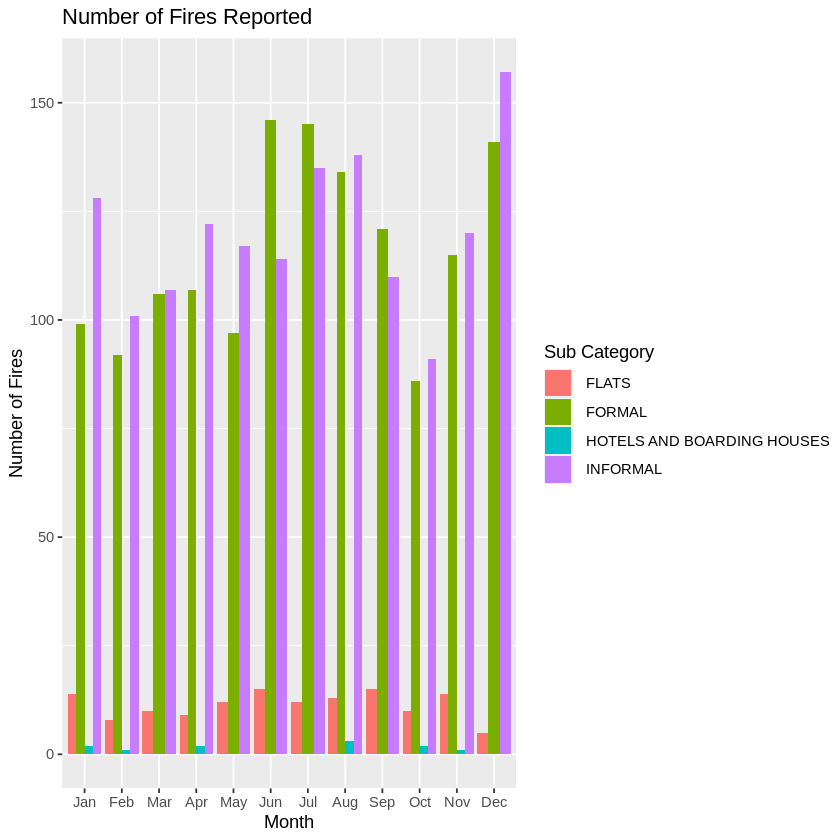

In [ ]:
q9 <- q6 %>%
  mutate(Months = factor(month(Date), levels = 1:12,
                          labels = c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul",
                                     "Aug", "Sep", "Oct", "Nov", "Dec"))) %>%
  filter( Category == "RESIDENTIAL FIRE ") %>%
  group_by(Months, `Sub Category`) %>%
  summarise(count = n())


ggplot(q9, aes(x = Months, y = count, fill = `Sub Category`)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Number of Fires Reported",
       x = "Month", y = "Number of Fires") +
  scale_fill_discrete(name = "Sub Category")

In [ ]:
map <- geojson_read(here("Data",file2), what = "sp")
map <- tidy(map)

ggplot() +
  geom_polygon(data = map, aes( x = long, y = lat, group = group),
               fill="#69b3a2", color="white") +
  theme_void() +
  coord_map()

In [ ]:
lookup <- read_csv("lookup.csv")

s3 <- q5 %>%
  group_by(Suburb) %>%
  summarise(count = sum(Count)) %>%
  rename(ID = Suburb)

S3.lookup <- left_join(lookup, s3) %>%
  rename(id = ID)

map <- map %>%
  mutate(id = as.numeric(id))

s3.map <- full_join(map, S3.lookup)

ggplot(data = s3.map) +
  geom_polygon(aes(x = long, y = lat, group = group, fill = count)) +
  scale_fill_continuous(name = "Number of Fires Reported") +
  theme_void() +
  coord_map()